In [1]:
import os
os.chdir("..")
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast
from epilearn.tasks.detection import Detection
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


## Customized Temporal Model

In [2]:
from epilearn.models.Temporal.base import BaseModel

class CustomizedTemporal(BaseModel):
    def __init__(self,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                num_layers,
                bidirectional,
                device = 'cpu'):
        super(CustomizedTemporal, self).__init__(device=device)
        self.num_feats = num_features
        self.hidden = hidden_size
        self.num_layers = num_layers
        self.bidirectional=bidirectional
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.lstm = nn.LSTM(input_size=self.num_feats, hidden_size=self.hidden, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph=None, states=None, dynamic_graph=None, **kargs):        
        # Forward propagate LSTM
        out, _ = self.lstm(feature)  # out: tensor of shape (batch, seq_length, hidden_size * num_directions)
        
        # Decode the last hidden state
        out = self.fc(out[:, -1, :])

        return out

    def initialize(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

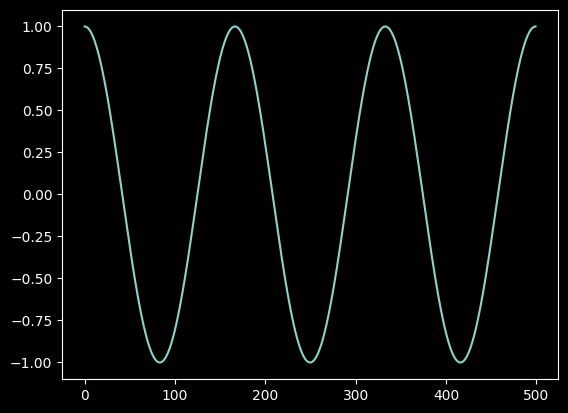

In [3]:
t = torch.linspace(0, 1, 500)
cos_wave = 1 * torch.cos(2 * torch.pi * 3 * t)

plt.plot(cos_wave.numpy())
plt.show()

In [4]:
inputs = cos_wave.reshape(-1, 1)
dataset = UniversalDataset(x=inputs, y=inputs)

In [6]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=CustomizedTemporal,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')


# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "num_layers": 2, "bidirectional": False, "device": 'cpu'}

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False,
                          model_args=model_args) # pass the hyperparameters of your model


 22%|██▎       | 9/40 [00:01<00:04,  6.30it/s]


KeyboardInterrupt: 

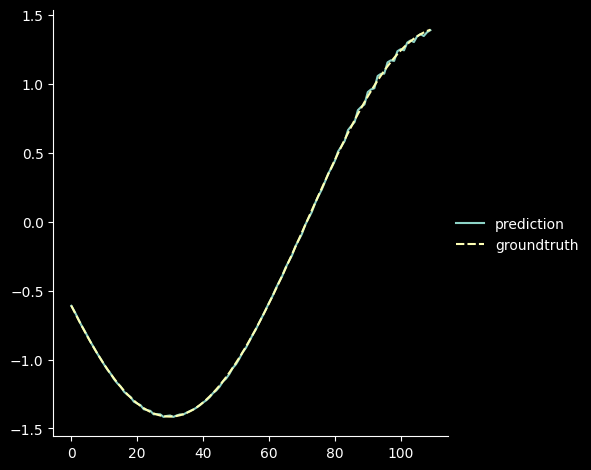

In [6]:
forecasts = task.plot_forecasts(task.test_dataset, index_range=[0,-1])

## Customized Spatial-Temporal Model

In [34]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

from epilearn.models.SpatialTemporal.base import BaseModel

class CustomizedSpatialTemporal(BaseModel):
    def __init__(self,
                num_nodes,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                num_channels_output,
                hidden_size,
                num_layers,
                bidirectional,
                device = 'cpu'):
        super(CustomizedSpatialTemporal, self).__init__(device=device)
        self.num_nodes = num_nodes
        self.num_feats = num_features
        self.hidden = hidden_size
        self.num_layers = num_layers
        self.bidirectional=bidirectional
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.num_out_channels = num_channels_output
        self.device = device

        self.gcn = GCNConv(in_channels=self.num_feats, out_channels=self.hidden)
        self.lstm = nn.LSTM(input_size=self.hidden, hidden_size=self.hidden, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.hidden, self.num_out_channels*self.horizon)

    def forward(self, feature, graph, states=None, dynamic_graph=None, **kargs):
        # message passing to update node features
        edge_index, _ = dense_to_sparse(graph)

        x = self.gcn(feature.float(), edge_index=edge_index)

        x = x.transpose(1,2).reshape(-1, self.lookback, self.hidden)
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch, seq_length, hidden_size * num_directions)
        # Decode the last hidden state
        out = out[:, -1, :]
        out = out.reshape(-1, self.num_nodes, self.hidden)
        out = self.fc(out).reshape(-1, self.num_nodes, self.horizon, self.num_out_channels)

        return out.transpose(1,2) # return shape (batch, horizon, num_nodes, num_channels_output)

    def initialize(self):
        pass

In [35]:
# generate n cosines with additional dimensions
num_nodes = 25
num_dimensions = 3  # Number of dimensions for the cos wave
t = torch.linspace(0, 1, 500)

# Generate frequencies for each node and dimension
frequencies = torch.randint(low=1, high=10, size=[num_nodes, num_dimensions])

# Generate cos waves for each dimension
cos_wave = torch.stack([torch.cos(2 * torch.pi * frequencies[:, i].unsqueeze(1) * t) for i in range(num_dimensions)], dim=-1)

# generate random graph
graph = torch.round(torch.rand([num_nodes, num_nodes]))

In [36]:
inputs = cos_wave.transpose(0,1)
dataset = UniversalDataset(x=inputs, y=inputs, graph=graph)

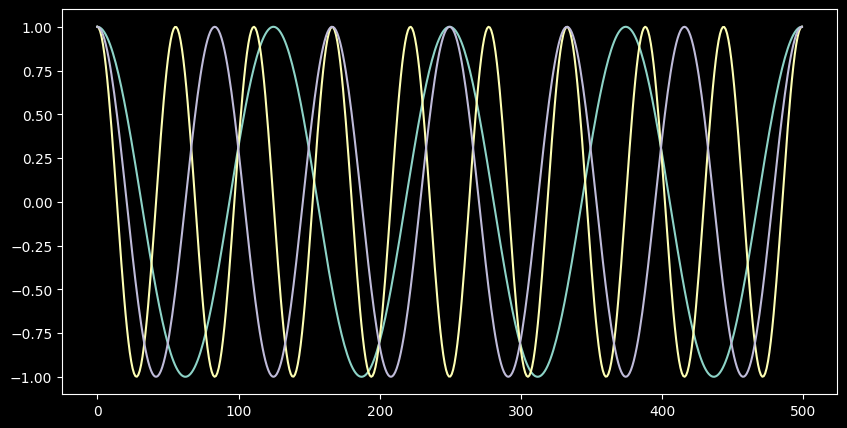

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(cos_wave[0, :, :].numpy())
plt.show()

100%|██████████| 3/3 [00:02<00:00,  1.44it/s]



Final Training loss: 0.8831415783684209
Final Validation loss: 0.9085097908973694


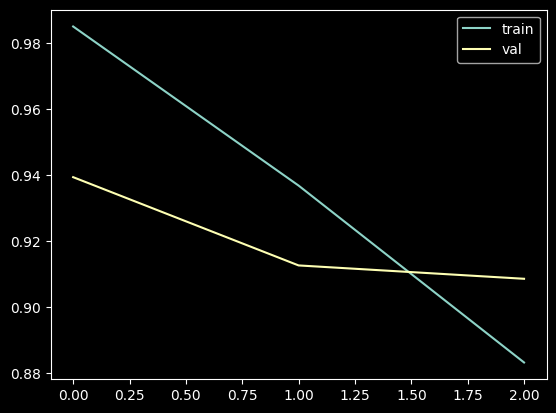

Test MSE: 0.819713830947876
Test MAE: 0.8038422465324402
Test RMSE: 0.9053804874420166


In [40]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_target()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=CustomizedSpatialTemporal,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')
model_args = {"num_nodes": num_nodes, "num_features": 3, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "num_channels_output": 3, "hidden_size": 16, "num_layers": 2, "bidirectional": False, "device": 'cpu'}
# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=3,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          lr=1e-3,
                          weight_decay=1e-2,
                          permute_dataset=False,
                          model_args=model_args
                          )

In [ ]:
# size, horizon, num_nodes, num_channels_output
result['predictions'].shape

torch.Size([62, 3, 25, 3])

## Customized Spatial Model

In [11]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

from epilearn.models.SpatialTemporal.base import BaseModel

class CustomizedSpatial(BaseModel):
    def __init__(self,
                num_nodes,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                device = 'cpu'):
        super(CustomizedSpatial, self).__init__(device=device)
        self.num_nodes = num_nodes
        self.num_feats = num_features
        self.hidden = hidden_size
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.gcn = GCNConv(in_channels=self.num_feats, out_channels=self.hidden)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph, states=None, dynamic_graph=None, **kargs):
        x = feature.transpose(1,2).reshape(-1, self.num_nodes, self.num_feats)
        edge_index, _ = dense_to_sparse(graph)

        x = self.gcn(x, edge_index=edge_index)

        
        out = self.fc(x)

        return out

    def initialize(self):
        pass

In [12]:
graph = graph = torch.round(torch.rand([num_nodes, num_nodes])) # nodes, nodes
features = torch.round(torch.rand((10,num_nodes,1,1))) # batch, nodes, time steps, channels
node_target = torch.round(torch.rand((10,num_nodes))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([25, 25])
features: torch.Size([10, 25, 1, 1])
node_target: torch.Size([10, 25])


In [13]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [14]:
from epilearn.tasks.detection import Detection

lookback = 1 # inputs size
horizon = 2 # predicts size; also seen as number of classes

task = Detection(prototype=CustomizedSpatial, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

model_args = {"num_nodes": num_nodes, "num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "device": 'cpu'}

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=False,
                          model_args=model_args
                          )

Model Initialized!


100%|██████████| 25/25 [00:00<00:00, 1332.40it/s]



Final Training loss: 0.6860760450363159
Final Validation loss: 0.6871914863586426
Test ACC: 0.5600000023841858
